# Report: Ex1 - ZooScanNet in the cloud

## Tore Aadland

Prior works:
http://benanne.github.io/2015/03/17/plankton.html
https://www.kaggle.com/c/datasciencebowl/discussion

Training imagenet fast and cheaply: https://www.fast.ai/2018/04/30/dawnbench-fastai/

First lets load required modules and seed the random number generators to make results reproducible:

In [1]:
import numpy as np
import random as rn
rn.seed(42)
np.random.seed(42)

Lets load some example data to get started and add some data augmentation increase the size of the training data.

In [ ]:
# Nice guide for doing data augmentation:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #rotation_range = 180, #make 180 for zooplankton
    rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    shear_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split = 0.05)

train_gen = datagen.flow_from_directory("./data/ZooScanSet/imgs/", target_size=(224,224), 
                                        color_mode="grayscale", class_mode="categorical", 
                                        batch_size=16, subset="training")
validation_gen = datagen.flow_from_directory("./data/ZooScanSet/imgs/", target_size=(224,224), 
                                        color_mode="grayscale", class_mode="categorical", 
                                        batch_size=16, subset="validation")

C:\Users\Tore\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Now, what is the distribution of the validation data?

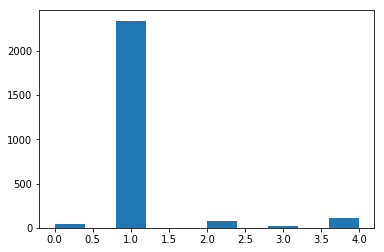

In [68]:
plt.hist(validation_gen.classes)
plt.show()

Clearly it needs to be balanced!

In [ ]:
# Following:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_gen.classes), 
                train_gen.classes)

# Alternatively I could have saved augmented data to a new folder.
# See: https://stackoverflow.com/questions/44666910/keras-image-preprocessing-unbalanced-data
# Might be better approach. Combine with:
# https://github.com/mdbloice/Augmentor and add some dimensionality data.

First I wan't to define the expected performance of a classifier that just captures the probability distribution of the different classes. I follow the example of François Chollet in "Deep learning with python": 

In [5]:
import copy
validation_labels = validation_gen.classes
validation_labels_copy = copy.copy(validation_labels)
np.random.shuffle(validation_labels_copy)
hits_array = np.array(validation_labels) == np.array(validation_labels_copy)
display(float(np.sum(hits_array)) / len(validation_labels))

0.8129579637485538

Visualize training image, a quick check to see that input data is still sane:

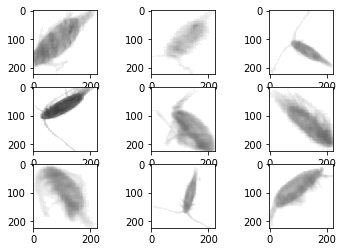

In [7]:
import matplotlib.pyplot as plt
import itertools
plt.clf()
j = 1

batch = next(train_gen)
for image in batch[0][:9]:
    #print(image.shape)
    plt.subplot(3, 3, j)
    plt.imshow(image.reshape((224,224,3)))
    j += 1
plt.show()

Now, lets load a pretrained model:

In [65]:
from keras.applications.mobilenet import MobileNet
pretrained_model = MobileNet(weights='imagenet')
pretrained_model.trainable = False
for _ in range(5):
    pretrained_model.layers.pop()

The lower layer is:

In [66]:
pretrained_model.layers[-1]

And customize it through the functional API. First I need to resize my input data to be consistent with the InceptionV3 model:

In [67]:
# Nice guide for transfer learning:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
from keras.layers import Input, Lambda, Concatenate, Reshape, Flatten, Dense
import tensorflow as tf

inputs = Input(shape=(224,224,1))

# From: https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63710
x = Concatenate()([inputs, inputs, inputs])    

# Used this to help me with the resize_image_layer:
# https://stackoverflow.com/questions/41903928/add-a-resizing-layer-to-a-keras-sequential-model
# x = Lambda( lambda image: tf.image.resize_images( 
#     image, ( 224, 224 ), 
#     method = tf.image.ResizeMethod.BICUBIC,
#     align_corners = True, # possibly important
#     preserve_aspect_ratio = True
# ) ) (x)

x = pretrained_model(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax', name="output")(x)

Then I need to make this input data feed into the Inception model:

In [68]:
from keras.models import Model
from keras.optimizers import SGD
model = Model(inputs=inputs, outputs=predictions)

# Following:
# https://datascience.stackexchange.com/questions/30659/what-are-the-consequences-of-not-freezing-layers-in-transfer-learning
for layer in model.layers[:-3]:
    layer.trainable = False
model.compile(optimizer=SGD(lr=0.01),
              loss="categorical_crossentropy", metrics=["accuracy"])

Double check that we are not accidentally training the pretrained model.

In [69]:
for layer in model.layers:
    print("{} is trainable? {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x000001C6098BFF98> is trainable? False
<keras.layers.merge.Concatenate object at 0x000001C6098BF6D8> is trainable? False
<keras.engine.training.Model object at 0x000001C60853E828> is trainable? False
<keras.layers.core.Dense object at 0x000001C6098ABF98> is trainable? True
<keras.layers.core.Dense object at 0x000001C6098AB6D8> is trainable? True
<keras.layers.core.Dense object at 0x000001C608FD67B8> is trainable? True


And fit the model to my training data:

In [7]:
# history = model.fit_generator(train_gen,
#                              steps_per_epoch=100, # training_gen.samples/train_gen.batch_size
#                               class_weight= class_weights,
#                               validation_data=validation_gen,
#                              validation_steps=validation_gen.samples/validation_gen.batch_size,
#                              epochs=10)

TODO:
Make a multi-input mode that take both features_native and image data as input.
See: https://keras.io/getting-started/functional-api-guide/
Make custom datagenerator using: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

Need some way of propagating the size of the image that is invariant to rotations. I am unhappy about the rigidity of the default ImageDataGenerator. I make my own custom data generator.

In [47]:
import os
from skimage import io
from skimage.transform import resize, rotate
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# See: http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate
# For additional possible transformations.
def augment_image(image):
    angle = np.random.random_integers(0,359)
    rotated_image =  rotate(image, angle, resize=False)
    return rotated_image


class MyGenerators(object):
    def __init__(self, path, val_fac=10, batch_size=16, target_size=(224,224)):
        self.path = path
        self.val_fac = val_fac
        self.batch_size = batch_size
        self.target_size = target_size
        
        self.labels = os.listdir(path)
        self.number_labels = len(self.labels)
        self.label_paths = {}
        self.label_len = {}
        self.images = {}
        for i, l in enumerate(self.labels):
            self.label_paths[i] = os.path.join(self.path, l)
            self.images[i] = (os.listdir(self.label_paths[i]))
            self.label_len[i] = len(self.images[i])
    
    def training_generator(self):
        while(True):
            output_list = []
            output_labels = []
            while not len(output_list) == self.batch_size:
                random_label = np.random.choice(self.number_labels)
                random_image = np.random.choice(self.label_len[random_label])
                if random_image % self.val_fac == 0:
                    continue
                output_labels.append(random_label)
                output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
            output_images = [io.imread(fp) for fp in output_list]
            output_statistics = [(image.shape[0], image.shape[1], np.sum(image==255)) for image in output_images]
            output_images = [augment_image(image) for image in output_images]
            output_images = [resize(image, self.target_size).reshape(224,224,1) for image in output_images]
            yield (np.stack(output_images), 
                  np.stack(output_statistics), 
                  to_categorical(np.stack(output_labels), num_classes = self.number_labels))
    
    def validation_generator(self):
        while(True):
            output_list = []
            output_labels = []
            while not len(output_list) == self.batch_size:
                random_label = np.random.choice(self.number_labels)
                random_image = self.val_fac*np.random.choice(int(self.label_len[random_label]/self.val_fac))
                assert random_image % self.val_fac == 0
                output_labels.append(random_label)
                output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
            output_images = [io.imread(fp) for fp in output_list]
            output_statistics = [(image.shape[0], image.shape[1], np.sum(image==255)) for image in output_images]
            #output_images = [augment_image(image) for image in output_images]
            output_images = [resize(image, self.target_size).reshape(224,224,1) for image in output_images]
            yield (np.stack(output_images), 
                  np.stack(output_statistics), 
                  to_categorical(np.stack(output_labels), num_classes = self.number_labels))

def make_image_generator(gen):
    while True:
        res = next(gen)
        yield res[0], res[2]

In [75]:
dategen = MyGenerators("./data/ZooScanSet/imgs", batch_size=6)
train_gen = make_image_generator(dategen.training_generator())
validation_gen = make_image_generator(dategen.validation_generator())

history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                              validation_data=validation_gen,
                             validation_steps=500,
                             epochs=2)

Epoch 1/2


C:\Users\Tore\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. Please call randint(0, 359 + 1) instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Tore\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


500/500 [==============================] - 58s 115ms/step - loss: 1.0220 - acc: 0.6113 - val_loss: 1.1890 - val_acc: 0.5210
Epoch 2/2
500/500 [==============================] - 58s 116ms/step - loss: 1.0197 - acc: 0.6087 - val_loss: 1.3052 - val_acc: 0.4797


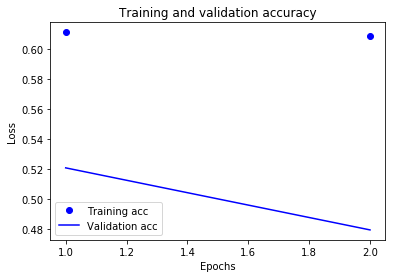

In [77]:
# From: https://livebook.manning.com/#!/book/deep-learning-with-python/chapter-3/165
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
import numpy as np
np.random.choice(1)

0

In [48]:
dategen = MyGenerators("./data/ZooScanSet/imgs", batch_size=6)
it = dategen.training_generator()

In [60]:
it = dategen.validation_generator()

In [61]:
test = next(it)

C:\Users\Tore\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [63]:

test[0][3][:,:,0]

array([[0.50542092, 0.70758929, 0.70758929, ..., 0.70758929, 0.70758929,
        0.50542092],
       [0.71428571, 1.        , 1.        , ..., 1.        , 1.        ,
        0.71428571],
       [0.71428571, 1.        , 1.        , ..., 1.        , 1.        ,
        0.71428571],
       ...,
       [0.71428571, 1.        , 1.        , ..., 1.        , 1.        ,
        0.71428571],
       [0.71428571, 1.        , 1.        , ..., 1.        , 1.        ,
        0.71428571],
       [0.50542092, 0.70758929, 0.70758929, ..., 0.70758929, 0.70758929,
        0.50542092]])

In [109]:
it = image_generator("./data/ZooScanSet/imgs", batch_size=6)
test = next(it)

C:\Users\Tore\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


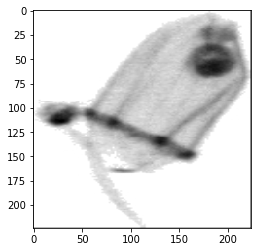

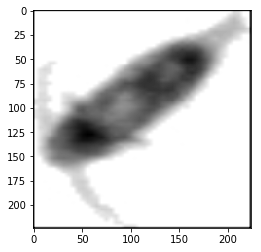

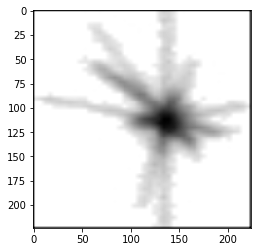

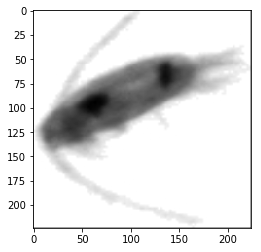

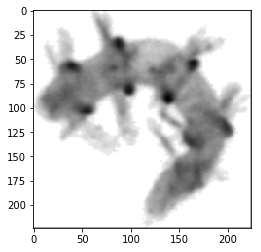

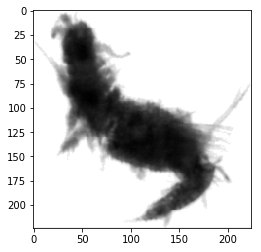

In [62]:
for i in test[0]:
    plt.imshow(i[:,:,0], cmap="gray")
    plt.show()

In [66]:
print(test[1:])

(array([[  129,   108, 69896],
       [   67,    49, 69896]]), array([4, 1]))


In [116]:
test[0][0].max()

1.0

In [ ]:
def data_generator(path, val_fac=10, batch_size=16, target_size=(224,224)):
    labels = os.listdir(path)
    number_labels = len(labels)
    label_paths = {}
    label_len = {}
    images = {}
    for i, l in enumerate(labels):
        label_paths[i] = os.path.join(path, l)
        images[i] = (os.listdir(label_paths[i]))
        label_len[i] = len(images[i])
    
    while(True):
        output_list = []
        output_labels = []
        while not len(output_list) == batch_size:
            random_label = np.random.choice(number_labels)
            random_image = np.random.choice(label_len[random_label])
            if random_image % val_fac == 0:
                continue
            output_labels.append(random_label)
            output_list.append(os.path.join(label_paths[random_label], images[random_label][random_image]))
        output_images = []
        output_statistics = []
        for i, fp in enumerate(output_list):
            image = io.imread(fp)
            output_statistics.append([image.shape[0], image.shape[1], np.sum(test==255)])
            output_images.append(resize(image, target_size)/255)
        yield np.stack(output_images), np.stack(output_statistics), np.stack(output_labels)

def image_generator(path, val_fac=10, batch_size=16, target_size=(224,224)):
    gen = data_generator(path, val_fac, batch_size, target_size)
    while True:
        res = next(gen)
        yield res[0], res[2]